# Developing and Evaluating Intrusion Detection Systems (IDS)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.models import Model
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, SparkTrials, space_eval
from hyperopt.early_stop import no_progress_loss
import mlflow
from mlflow.models.signature import infer_signature
import sdv
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Print versions
print(mlflow.__version__)
print(tf.__version__)
print(sdv.version.public)

# MLflow configuration
mlflow.tensorflow.autolog()


2.11.1
2.15.0
1.10.0


## Data Preparation 


In [0]:
# Load dataset 
processed_file_path = '/dbfs/FileStore/m332479/GANs_forCyberSecurity/processed_RT_IOT2022.csv'
df = pd.read_csv(processed_file_path , index_col=0).reset_index()
df = df.dropna()

# Single Table Metadata API


metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

print(metadata)
df

{
    "columns": {
        "fwd_init_window_size": {
            "sdtype": "numerical"
        },
        "id_resp_p": {
            "sdtype": "numerical"
        },
        "fwd_pkts_payload_avg": {
            "sdtype": "numerical"
        },
        "fwd_pkts_payload_min": {
            "sdtype": "numerical"
        },
        "fwd_URG_flag_count": {
            "sdtype": "categorical"
        },
        "flow_SYN_flag_count": {
            "sdtype": "numerical"
        },
        "fwd_header_size_min": {
            "sdtype": "numerical"
        },
        "fwd_header_size_max": {
            "sdtype": "numerical"
        },
        "flow_pkts_payload_tot": {
            "sdtype": "numerical"
        },
        "flow_pkts_payload_max": {
            "sdtype": "numerical"
        },
        "flow_iat_min": {
            "sdtype": "numerical"
        },
        "payload_bytes_per_second": {
            "sdtype": "numerical"
        },
        "fwd_last_window_size": {
            "sd

fwd_init_window_size  id_resp_p  ...  proto_tcp  proto_udp
0                   0.980240   0.028797  ...        1.0        0.0
1                   0.980240   0.028797  ...        1.0        0.0
2                   0.980240   0.028797  ...        1.0        0.0
3                   0.980240   0.028797  ...        1.0        0.0
4                   0.980240   0.028797  ...        1.0        0.0
...                      ...        ...  ...        ...        ...
122982              0.015625   0.302819  ...        1.0        0.0
122983              0.015625   0.303446  ...        1.0        0.0
122984              0.015625   0.305862  ...        1.0        0.0
122985              0.015625   0.305938  ...        1.0        0.0
122986              0.015625   0.309242  ...        1.0        0.0

[122987 rows x 41 columns]

In [0]:
synthesizer = CTGANSynthesizer(
    metadata, # required
    enforce_rounding=False,
    epochs=500,
    batch_size = 500,
    discriminator_dim = (256, 256),
    discriminator_decay = 2e-4,
    discriminator_steps = 1,
    embedding_dim = 128,
    generator_decay = 1e-6,
    generator_dim = (256, 256),
    generator_lr = 2e-4,
    log_frequency = True,
    pac = 10,
    verbose=True
)
synthesizer.get_parameters()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-72467700-53a8-44ce-a53c-2bd34bdd33c4/lib/python3.10/site-packages/sdv/single_table/base.py:79: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


{'enforce_min_max_values': True,
 'enforce_rounding': False,
 'locales': None,
 'embedding_dim': 128,
 'generator_dim': (256, 256),
 'discriminator_dim': (256, 256),
 'generator_lr': 0.0002,
 'generator_decay': 1e-06,
 'discriminator_lr': 0.0002,
 'discriminator_decay': 0.0002,
 'batch_size': 500,
 'discriminator_steps': 1,
 'log_frequency': True,
 'verbose': True,
 'epochs': 500,
 'pac': 10,
 'cuda': True}

In [0]:
synthesizer.fit(df)
synthesizer.get_loss_values()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8901e96cb0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_ca

---------------------------------------------------------------------------
ContextualVersionConflict                 Traceback (most recent call last)
File <command-4389108168478138>, line 1
----> 1 synthesizer.fit(df)
      2 synthesizer.get_loss_values()

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-72467700-53a8-44ce-a53c-2bd34bdd33c4/lib/python3.10/site-packages/sdv/single_table/base.py:396, in BaseSynthesizer.fit(self, data)
    394 self._random_state_set = False
    395 processed_data = self._preprocess(data)
--> 396 self.fit_processed_data(processed_data)

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-72467700-53a8-44ce-a53c-2bd34bdd33c4/lib/python3.10/site-packages/sdv/single_table/base.py:382, in BaseSynthesizer.fit_processed_data(self, processed_data)
    380 self._fitted = True
    381 self._fitted_date = datetime.datetime.today().strftime('%Y-%m-%d')
--> 382 self._fitted_sdv_version = pkg_resources.get_distribution('sdv').version

File /databricks/python/lib/python3.1

In [0]:
synthesizer.save(
    filepath='/dbfs/FileStore/m332479/GANs_forCyberSecurity/models/cGAN_IDS_synthesizer.pkl'
)

In [0]:
from sdv.single_table import CTGANSynthesizer

synthesizer = CTGANSynthesizer.load(
    filepath='/dbfs/FileStore/m332479/GANs_forCyberSecurity/models/cGAN_IDS_synthesizer.pkl'
)

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.1.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [0]:
loss_df = synthesizer.get_loss_values()
loss_df

Epoch   Generator Loss Discriminator Loss
0        0  tensor(-1.7242)     tensor(0.1182)
1        1   tensor(0.0225)    tensor(-1.0795)
2        2  tensor(-0.7127)    tensor(-0.5615)
3        3  tensor(-1.4252)     tensor(0.2279)
4        4  tensor(-0.4254)    tensor(-0.3173)
..     ...              ...                ...
495    495  tensor(-1.4544)     tensor(0.3386)
496    496  tensor(-0.4580)    tensor(-0.6651)
497    497  tensor(-0.8511)     tensor(0.3293)
498    498  tensor(-1.6983)    tensor(-1.2529)
499    499  tensor(-1.9515)     tensor(0.1584)

[500 rows x 3 columns]

In [0]:
# Convert all the tensor values to floats
loss_df['Generator Loss'] = loss_df['Generator Loss'].apply(lambda x: x.item())
loss_df['Discriminator Loss'] = loss_df['Discriminator Loss'].apply(lambda x: x.item())
loss_df

Epoch  Generator Loss  Discriminator Loss
0        0       -1.724172            0.118238
1        1        0.022538           -1.079530
2        2       -0.712739           -0.561484
3        3       -1.425224            0.227913
4        4       -0.425406           -0.317293
..     ...             ...                 ...
495    495       -1.454440            0.338622
496    496       -0.458007           -0.665108
497    497       -0.851106            0.329337
498    498       -1.698339           -1.252914
499    499       -1.951520            0.158351

[500 rows x 3 columns]

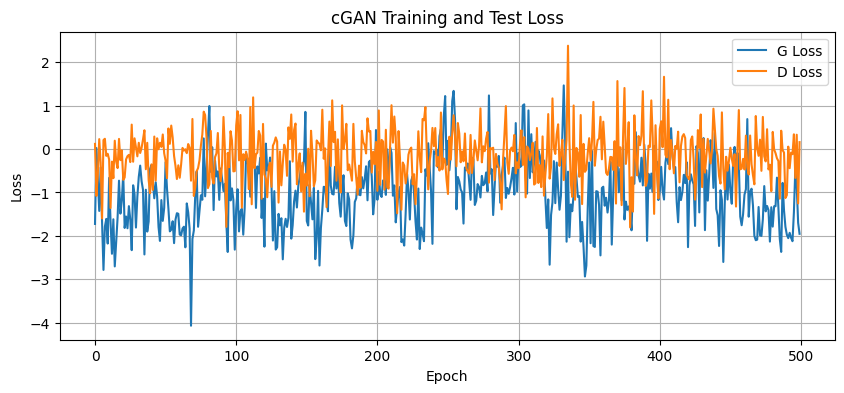

In [0]:
# Set 'Epochs' as the index
loss_df.set_index('Epoch', inplace=True)
  
# Save the DataFrame as a CSV or log it as an artifact in MLflow
loss_df.to_csv("/dbfs/FileStore/m332479/GANs_forCyberSecurity/loss_df_sdv.csv")
mlflow.log_artifact("/dbfs/FileStore/m332479/GANs_forCyberSecurity/loss_df_sdv.csv")

# Plot the loss.
fig, ax = plt.subplots(figsize=(10, 4))
loss_df.plot(ax=ax)
plt.title('cGAN Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['G Loss', 'D Loss'])
plt.grid(True)

# Make sure to use a correct path to save the plot.
plot_path =  "/dbfs/FileStore/m332479/GANs_forCyberSecurity/plots/loss_plot_sdv.png"
plt.savefig(plot_path)


In the context of a Conditional Generative Adversarial Network (CGAN), both the generator and the discriminator have specific roles:

`Generator`: It tries to generate data that is indistinguishable from real data, given some condition or class label.

`Discriminator`: It tries to distinguish between real data and the fake data generated by the generator.
During training, these two networks are in a sort of competition: the generator tries to improve its data generation to fool the discriminator, while the discriminator tries to get better at distinguishing real from fake.

`Loss Functions`: Typically, the loss functions for both networks are designed to measure how well each is performing its task.

`Generator Loss`: This often reflects how poorly the generator is at fooling the discriminator. A high loss means the discriminator can easily tell its data is fake, while a lower loss means the generator is producing more believable data.

`Discriminator Loss`: This reflects how well the discriminator is at identifying real and fake data. A high loss would mean the discriminator is often fooled by the generator, while a lower loss would mean it's proficient at telling real from fake.

`Negative Loss Values`: In the case of CGANs, or GANs in general, negative loss values can occur depending on the design of the loss functions. Some loss functions (like Wasserstein Loss) can naturally lead to negative values because they measure a kind of "distance" between distributions. Other reasons for negative losses can include:
Logarithms in Loss Functions: Traditional GAN loss functions involve logarithms, which can lead to negative values since the logarithm of a number between 0 and 1 is negative. 

## Sampling Realistic Synthetic Data

In [0]:
synthetic_data = synthesizer.sample(num_rows=1_000_000)

synthetic_data

fwd_init_window_size  id_resp_p  ...  proto_tcp  proto_udp
0                   0.001038   0.000397  ...        1.0        0.0
1                   0.016396   0.112002  ...        1.0        0.0
2                   0.001030   0.000274  ...        1.0        0.0
3                   0.000035   0.000449  ...        0.0        1.0
4                   0.000977   0.000000  ...        1.0        0.0
...                      ...        ...  ...        ...        ...
999995              0.977971   0.001575  ...        1.0        0.0
999996              0.000911   0.000654  ...        1.0        0.0
999997              0.001172   0.000062  ...        1.0        0.0
999998              0.979978   0.034725  ...        1.0        0.0
999999              0.000561   0.000894  ...        1.0        0.0

[1000000 rows x 41 columns]

In [0]:
synthetic_data.Attack_type.value_counts()

Attack_type
DOS_SYN_Hping          495013
Thing_Speak            165057
ARP_poisioning         129335
MQTT_Publish            63574
NMAP_XMAS_TREE_SCAN     44632
NMAP_UDP_SCAN           35684
Wipro_bulb              26285
NMAP_OS_DETECTION       16215
DDOS_Slowloris          13560
NMAP_TCP_scan           10645
Name: count, dtype: int64

In [0]:
df.Attack_type.value_counts()

Attack_type
DOS_SYN_Hping          94659
Thing_Speak             8108
ARP_poisioning          7750
MQTT_Publish            4146
NMAP_UDP_SCAN           2590
NMAP_OS_DETECTION       2000
NMAP_XMAS_TREE_SCAN     1945
NMAP_TCP_scan           1002
DDOS_Slowloris           534
Wipro_bulb               253
Name: count, dtype: int64

## Evaluation

In [0]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# 1. perform basic validity checks
diagnostic = run_diagnostic(df, synthetic_data, metadata)
diagnostic

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 290.81it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%


Interpreting the Score:
The score should be 100%. The diagnostic report checks for basic data validity and data structure issues. You should expect the score to be perfect for any of the default SDV synthesizers.

What's Included?

**Data Validity:** Basic validity checks for each of the columns:
1. Primary keys must always be unique and non-null
2. Continuous values in the synthetic data must adhere to the min/max range in the real data
3. Discrete values in the synthetic data must adhere to the same categories as the real data.

**Structure:** Checks to ensure the real and synthetic data have the same column names


In [0]:
# 2. measure the statistical similarity
quality_report = evaluate_quality(df, synthetic_data, metadata)
quality_report

Generating report ...
(1/2) Evaluating Column Shapes: : 100%|██████████| 41/41 [00:07<00:00,  5.32it/s]
(2/2) Evaluating Column Pair Trends: :  29%|██▉       | 24

*** WARNING: max output size exceeded, skipping output. ***

(2/2) Evaluating Column Pair Trends: : 100%|██████████| 820/820 [09:22<00:00,  1.46it/s]

Overall Score: 74.29%

Properties:
- Column Shapes: 67.98%
- Column Pair Trends: 80.6%


**Data Quality**

The Quality Report checks for statistical similarity between the real and the synthetic data. Use this to discover which patterns the synthetic data has captured from the real data.

Interpreting the Score: Your score will vary from 0% to 100%. This value tells you how similar the synthetic data is to the real data.
A 100% score means that the patterns are exactly the same. For example, if you compared the real data with itself (identity), the score would be 100%.
A 0% score means the patterns are as different as can be. This would entail that the synthetic data purposefully contains anti-patterns that are opposite from the real data.
Any score in the middle can be interpreted along this scale. For example, a score of 80% means that the synthetic data is about 80% similar to the real data — about 80% of the trends are similar. The quality score is expected to vary, and you may never achieve exactly 100% quality. That's ok! The SDV synthesizers are designed to estimate patterns, meaning that they may smoothen, extrapolate, or noise certain parts of the data. 

**Column Shapes:** The statistical similarity between the real and synthetic data for single columns of data. This is often called the marginal distribution of each column.

**Column Pair Trends** The statistical similarity between the real and synthetic data for pairs of columns. This is often called the correlation or bivariate distributions of the columns.


In [0]:
# Loop through each column in the DataFrame


# Retrieve the column names from the real_data DataFrame
column_names = df.columns[:20]  # Get the first 20 columns

for column_name in column_names:
    # Generate the column plot for each column
    fig = get_column_plot(
        real_data=df,
        synthetic_data=synthetic_data,
        metadata=metadata,
        column_name=column_name
    )
    
    # Display the figure
    fig.show()

    # Optionally, save the figure to a file
    # fig.write_image(f"{column_name}_plot.png")

    # To prevent open figures from accumulating, close the figure
    plt.close('all')


In [0]:
# save the data as a CSV
synthetic_data.to_csv("/dbfs/FileStore/m332479/GANs_forCyberSecurity/synthetic_data.csv", index=False)